# Miscentering Distribution eROSITA

L'obiettivo è analizzare la distribuzione del miscentering negli ammassi di galassie utilizzando i dati della prima data release di eROSITA. L'analisi si concentrerà sulla distribuzione delle distanze normalizzate (BCG_offset_R500), con l'obiettivo di sviluppare modelli predittivi basati sui parametri rho, sigma0 e sigma1.

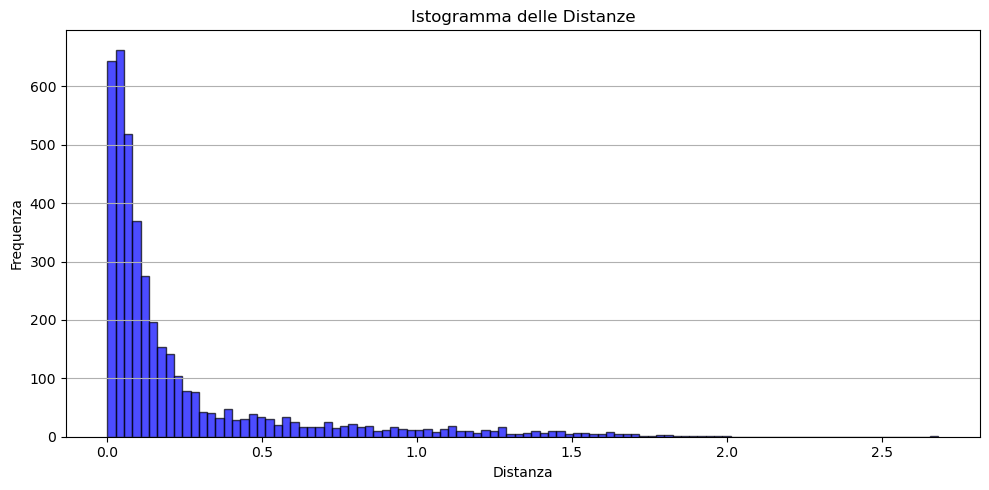

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Leggo il CSV
data = pd.read_csv('dati.csv')
distance = data['DISTANCE'].values

# Crea l'istogramma
plt.figure(figsize=(10, 5))
plt.hist(distance, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Istogramma delle Distanze')
plt.xlabel('Distanza')
plt.ylabel('Frequenza')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


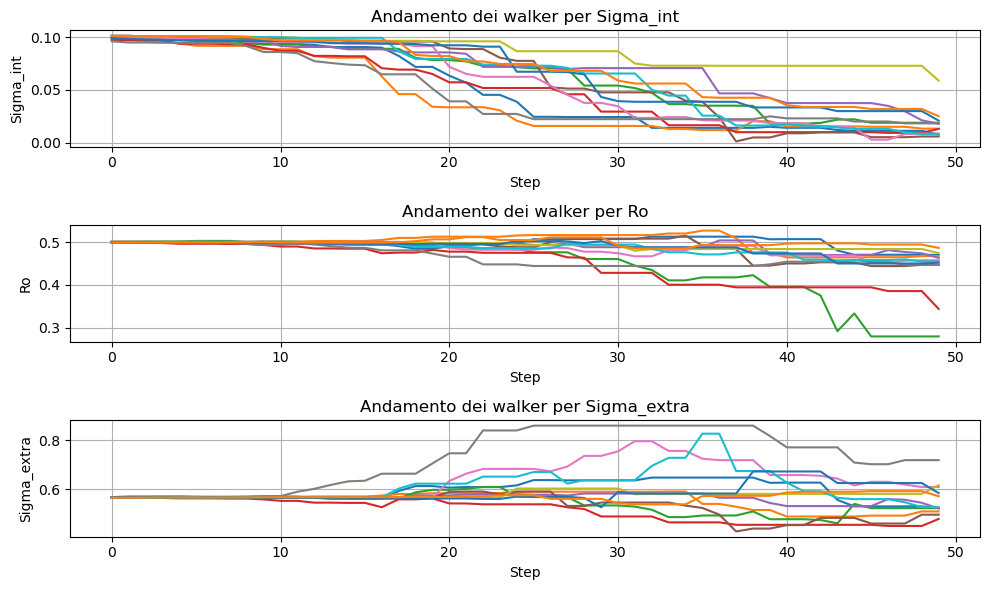

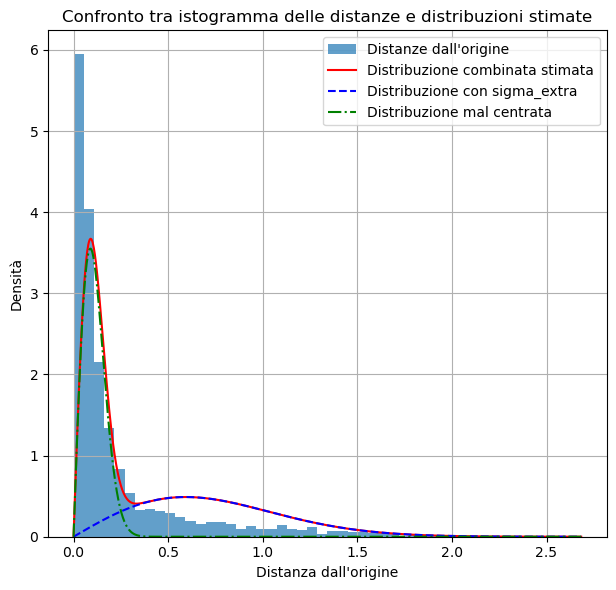

Parametro sigma_int stimato: 0.05318800793530491
Parametro ro stimato: 0.4782276589201373
Parametro sigma_extra stimato: 0.5883564548567686


C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.95it/s]


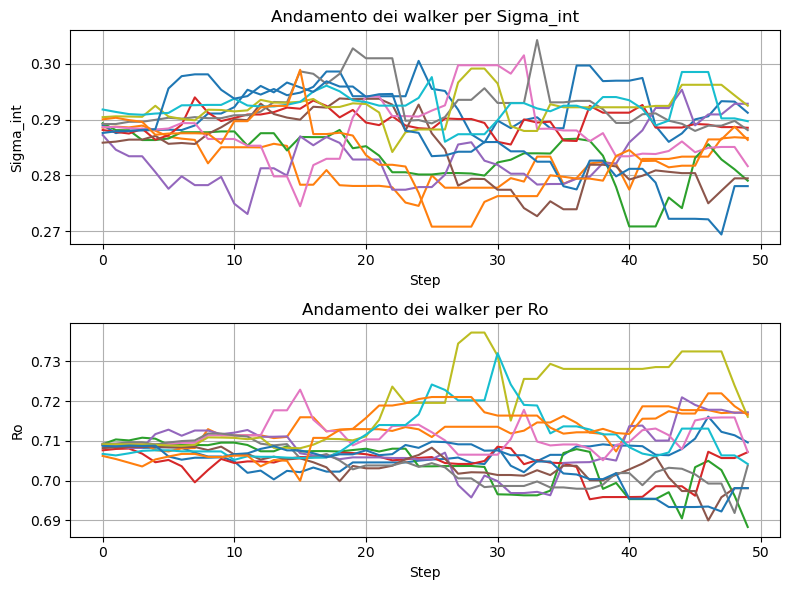

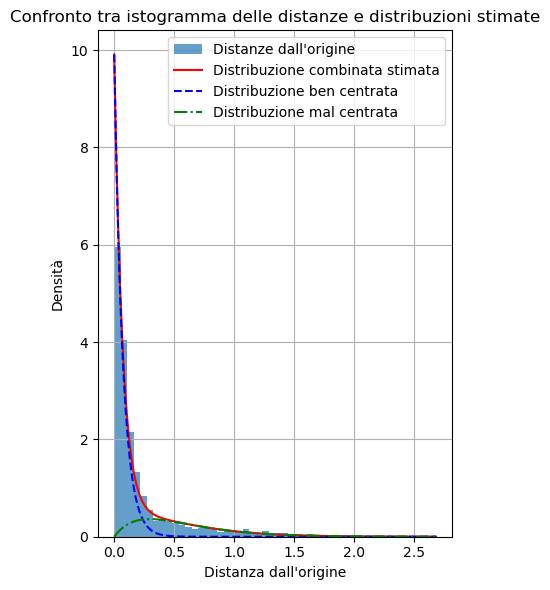

Parametro sigma_int stimato: 0.2875237839900007
Parametro ro stimato: 0.7085087754860637


In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds
import emcee
import matplotlib.pyplot as plt

# Definizione della funzione di densità di probabilità combinata (Saro 2015) con sigma_extra
def combined_rayleigh_pdf(x, sigma_int, sigma_measure, ro, sigma_extra):
    sigma_combined = np.sqrt(sigma_int**2 + sigma_measure**2)
    sigma_term1 = np.sqrt(sigma_measure**2 + sigma_extra**2)
    term1 = ro * (x / sigma_term1**2) * np.exp(-x**2 / (2 * sigma_term1**2))
    term2 = (1-ro) * (x / sigma_combined**2) * np.exp(-x**2 / (2 * sigma_combined**2))
    return term1 + term2

# Logaritmo della funzione di verosimiglianza
def log_likelihood(data, errors, sigma_int, ro, sigma_extra):
    ll = 0
    for x, sigma_measure in zip(data, errors):
        ll += np.log(combined_rayleigh_pdf(x, sigma_int, sigma_measure, ro, sigma_extra))
    return ll

# Logaritmo del posterior
def log_posterior(params, data, errors):
    sigma_int, ro, sigma_extra = params
    if sigma_int <= 0 or ro < 0 or ro > 1 or sigma_extra <= 0:
        return -np.inf
    return log_likelihood(data, errors, sigma_int, ro, sigma_extra)

# Funzione negativa del log-likelihood per l'ottimizzazione
def NegLL(params, data, errors):
    return -log_posterior(params, data, errors)

# Leggi il CSV
data = pd.read_csv('dati.csv')

# Estrai le colonne di interesse
errors = data['ERROR'].values
distance = data['DISTANCE'].values

# Definizione dei bounds (vincoli) per l'ottimizzazione iniziale
bounds = Bounds([0, 0, 0.4], [0.15, 1, np.inf])

# Ottimizzazione per trovare i valori iniziali dei parametri con vincoli
initial_guess = [0.1, 0.5, 0.5]  # Valori iniziali per i parametri
result = minimize(NegLL, initial_guess, args=(distance, errors), bounds=bounds)
sigma_int_initial, ro_initial, sigma_extra_initial = result.x

# Posizioni iniziali dei walker
ndim = 3  # Numero di parametri
nwalkers = 12  # Numero di walker
pos = np.array([sigma_int_initial, ro_initial, sigma_extra_initial]) + 1e-3 * np.random.randn(nwalkers, ndim)

# Avvio dell'algoritmo MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[distance, errors])
sampler.run_mcmc(pos, nsteps=50, progress=True)

# Estrazione delle catene di Markov per i parametri
samples = sampler.get_chain(flat=True)

# Calcola la media dei valori di ciascun parametro escludendo i primi passi di burn-in per ogni walker
burn_in = int(1000 * 0.1)
sigma_int_estimated = np.mean(samples[burn_in:, 0])
ro_estimated = np.mean(samples[burn_in:, 1])
sigma_extra_estimated = np.mean(samples[burn_in:, 2])

# Plot dell'andamento dei walker
plt.figure(figsize=(10, 6))
labels = ['Sigma_int', 'Ro', 'Sigma_extra']
for i in range(ndim):
    plt.subplot(ndim, 1, i + 1)
    for j in range(nwalkers):
        plt.plot(sampler.get_chain()[:, j, i], label=f"Walker {j + 1}")
    plt.xlabel("Step")
    plt.ylabel(labels[i])
    plt.title(f"Andamento dei walker per {labels[i]}")
    plt.grid(True)
plt.tight_layout()
plt.show()

# Calcola le distribuzioni combinate e separate
x_vals = np.linspace(0, max(distance), 1000)
combined_pdf = combined_rayleigh_pdf(x_vals, sigma_int_estimated, np.mean(errors), ro_estimated, sigma_extra_estimated)
term1_pdf = ro_estimated * (x_vals / (np.mean(errors)**2 + sigma_extra_estimated**2)) * np.exp(-x_vals**2 / (2 * (np.mean(errors)**2 + sigma_extra_estimated**2)))
sigma_combined = np.sqrt(sigma_int_estimated**2 + np.mean(errors)**2)
term2_pdf = (1 - ro_estimated) * (x_vals / sigma_combined**2) * np.exp(-x_vals**2 / (2 * sigma_combined**2))

# Plot dell'istogramma delle distanze e delle distribuzioni combinate stimate
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(distance, bins=50, density=True, alpha=0.7, label='Distanze dall\'origine')
plt.plot(x_vals, combined_pdf, 'r-', label='Distribuzione combinata stimata')
plt.plot(x_vals, term1_pdf, 'b--', label='Distribuzione con sigma_extra')
plt.plot(x_vals, term2_pdf, 'g-.', label='Distribuzione mal centrata')
plt.title('Confronto tra istogramma delle distanze e distribuzioni stimate')
plt.xlabel('Distanza dall\'origine')
plt.ylabel('Densità')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampiamo i valori stimati dei parametri
print("Parametro sigma_int stimato:", sigma_int_estimated)
print("Parametro ro stimato:", ro_estimated)
print("Parametro sigma_extra stimato:", sigma_extra_estimated)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee

# Definizione della funzione di densità di probabilità combinata (Zhang 2019)
def combined_pdf_zhang(x, sigma_int, sigma_measure, ro):
    sigma_combined = np.sqrt(sigma_int**2 + sigma_measure**2)
    term1 = ro / sigma_measure  * np.exp(-x/sigma_measure)
    term2 = (1-ro) * (x / sigma_combined**2) * np.exp(-x/sigma_combined)
    return term1 + term2

# Logaritmo della funzione di verosimiglianza
def log_likelihood(data, errors, sigma_int, ro):
    ll = 0
    for x, sigma_measure in zip(data, errors):
        ll += np.log(combined_pdf_zhang(x, sigma_int, sigma_measure, ro))
    return ll

# Logaritmo del posterior
def log_posterior(params, data, errors):
    sigma_int, ro = params
    if sigma_int <= 0 or ro < 0 or ro > 1:
        return -np.inf
    return log_likelihood(data, errors, sigma_int, ro)

# Funzione negativa del log-likelihood per l'ottimizzazione
def NegLL(params, data, errors):
    return -log_posterior(params, data, errors)

# Leggi il CSV
data = pd.read_csv('dati.csv')

# Estrai le colonne di interesse
errors = data['ERROR'].values
distance = data['DISTANCE'].values

# Definizione del numero di dimensioni e dei walker
ndim = 2
nwalkers = 12
nsteps = 50

# Ottimizzazione per trovare i valori iniziali dei parametri
initial_guess = [1.0, 0.5]
result = minimize(NegLL, initial_guess, args=(distance, errors))
sigma_int_initial, ro_initial = result.x

# Posizioni iniziali dei walker
pos = result.x + 1e-3 * np.random.randn(nwalkers, ndim)

# Avvio dell'algoritmo MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[distance, errors])
sampler.run_mcmc(pos, nsteps, progress=True)

# Estrazione delle catene di Markov per i parametri
samples = sampler.get_chain(flat=True)

# Calcola la media dei valori di ciascun parametro escludendo i primi passi di burn-in per ogni walker
burn_in = int(nsteps * 0.1)
sigma_int_estimated = np.mean(samples[burn_in:, 0])
ro_estimated = np.mean(samples[burn_in:, 1])

# Plot dell'andamento dei walker
plt.figure(figsize=(8, 6))
labels = ['Sigma_int', 'Ro']
for i in range(ndim):
    plt.subplot(ndim, 1, i + 1)
    for j in range(nwalkers):
        plt.plot(sampler.get_chain()[:, j, i], label=f"Walker {j + 1}")
    plt.xlabel("Step")
    plt.ylabel(labels[i])
    plt.title(f"Andamento dei walker per {labels[i]}")
    plt.grid(True)
plt.tight_layout()
plt.show()

# Calcola le distribuzioni combinate e separate
x_vals = np.linspace(0, max(distance), 1000)
combined_pdf = combined_pdf_zhang(x_vals, sigma_int_estimated, np.mean(errors), ro_estimated)
term1_pdf = ro_estimated / np.mean(errors) * np.exp(-x_vals / np.mean(errors))
sigma_combined = np.sqrt(sigma_int_estimated**2 + np.mean(errors)**2)
term2_pdf = (1 - ro_estimated) * (x_vals / sigma_combined**2) * np.exp(-x_vals / sigma_combined)

# Plot dell'istogramma delle distanze e delle distribuzioni combinate stimate
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.hist(distance, bins=50, density=True, alpha=0.7, label='Distanze dall\'origine')
plt.plot(x_vals, combined_pdf, 'r-', label='Distribuzione combinata stimata')
plt.plot(x_vals, term1_pdf, 'b--', label='Distribuzione ben centrata')
plt.plot(x_vals, term2_pdf, 'g-.', label='Distribuzione mal centrata')
plt.title('Confronto tra istogramma delle distanze e distribuzioni stimate')
plt.xlabel('Distanza dall\'origine')
plt.ylabel('Densità')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Stampiamo i valori stimati dei parametri
print("Parametro sigma_int stimato:", sigma_int_estimated)
print("Parametro ro stimato:", ro_estimated)
